In [1]:
# import libs
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import datetime as dt
from scipy.stats import norm, chi2_contingency
import requests
from urllib.parse import urlencode


In [2]:
# Чтение данных из облака
def download_link(public_key):

    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

In [3]:
# Загрузка данных
reg_date_df = pd.read_csv(download_link('https://disk.yandex.ru/d/4a8ZnvApDsAiXQ'), sep=';')
auth_date_df = pd.read_csv(download_link('https://disk.yandex.ru/d/mQkHtQuHLrXQbQ'), sep=';')

Задание 1.
Написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока)

In [4]:
# Конвертирование даты для дальнейшей работы
reg_date_df['reg_date'] = reg_date_df.reg_ts.apply(lambda x: dt.datetime.fromtimestamp(x))
reg_date_df['reg_date'] = reg_date_df.reg_date.apply(lambda x: dt.date(x.year, x.month, x.day))

auth_date_df['auth_date'] = auth_date_df.auth_ts.apply(lambda x: dt.datetime.fromtimestamp(x))
auth_date_df['auth_date'] = auth_date_df.auth_date.apply(lambda x: dt.date(x.year, x.month, x.day))

In [5]:
merged_df = reg_date_df[['uid', 'reg_date']].merge(auth_date_df[['uid', 'auth_date']])

In [6]:
merged_df['date_diff'] = (merged_df.auth_date - merged_df.reg_date).apply(lambda x: x.days)

<AxesSubplot:title={'center':'unique users by reg_date'}, xlabel='reg_date', ylabel='nunique users'>

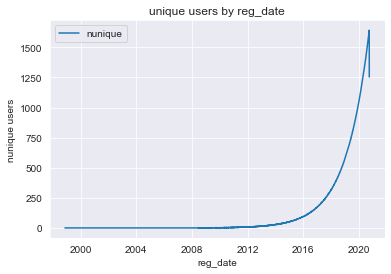

In [7]:
# Долгое время в когортах было малое кол-во зарегистрировавшихся пользователей.
# Для первоначальной фильтрации посмотрим, в какой год примерно рост пользователей стал значительным.

merged_df.groupby('reg_date', as_index=False)\
    .agg(nunique=('uid', 'nunique'))\
    .plot(x='reg_date', 
          y='nunique',
          title = 'unique users by reg_date',
          ylabel='nunique users')

In [8]:
def get_cohort_analysis(df, date_diff=10, start_analysis_date='2016-01-01'):
    """
    Функция рассчитывает Retention по когортам. Когорта - день регистрации.
    Для уменьшения итоговой таблицы принята фильтрация: стандартно указан Retention первых 10 дней с момента регистрации, когорты в расчёте от 2016 года.
    :param df: исследуемый ДФ;
    :param date_diff: диапазон от даты регистрации до указанного дня для отображения retention;
    :param start_analysis_date: дата начала исследования.
    """
    start_analysis_date = pd.to_datetime(start_analysis_date).date()

    grouped_df = df.query("date_diff <= @date_diff & reg_date >= @start_analysis_date")\
        .groupby(['reg_date', 'date_diff'], as_index=False)\
        .agg(unique_ids=('uid', 'nunique'))\
        .rename(columns={'date_diff': 'days_after_reg'})

    cohort_counts = grouped_df.pivot_table(index='reg_date', columns='days_after_reg', values='unique_ids', fill_value=0)
    cohort_size = cohort_counts.iloc[:,0]

    retention_table = cohort_counts.divide(cohort_size, axis=0).round(3) * 100
    retention_table.insert(0, 'cohort_size', cohort_size)

    return retention_table

In [9]:
get_cohort_analysis(merged_df, 10, '1995-01-01')

days_after_reg,cohort_size,0,1,2,3,4,5,6,7,8,9,10
reg_date,,,,,,,,,,,,
1998-11-18,1,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999-07-23,1,100.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
2000-01-14,1,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-05-28,1,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-09-16,1,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-19,1633,100.0,1.8,3.6,4.7,4.1,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-20,1636,100.0,2.3,4.3,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-21,1638,100.0,1.8,3.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [10]:
# Чтение данных
def download_link(public_key):

    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

test_data_link = 'https://disk.yandex.ru/d/12gk_ATEeBZm4A'

In [11]:
test_data = pd.read_csv(download_link(test_data_link), sep=';')

In [12]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [13]:
# Разделим на группы
a_group = test_data.query("testgroup == 'a'")[['user_id', 'revenue']]
b_group = test_data.query("testgroup == 'b'")[['user_id', 'revenue']]

In [14]:
a_group.describe()

,user_id,revenue
count,202103.000000,202103.000000
mean,202555.909843,25.413720
std,116802.329266,920.768137
min,2.000000,0.000000
25%,101502.500000,0.000000
50%,202988.000000,0.000000
75%,303559.000000,0.000000
max,404769.000000,37433.000000


In [15]:
b_group.describe()

,user_id,revenue
count,202667.000000,202667.000000
mean,202215.564389,26.751287
std,116891.926690,287.324162
min,1.000000,0.000000
25%,100855.500000,0.000000
50%,201821.000000,0.000000
75%,303602.500000,0.000000
max,404770.000000,4000.000000


In [16]:
# Проверим указанные в задании данные
paying_users = test_data.query('revenue > 0')\
    .groupby('testgroup', as_index=False)\
    .agg(paying_users=('user_id', 'nunique'))

grouped_test_data = test_data.groupby('testgroup', as_index=False)\
    .agg(nunuqie_users=('user_id', 'nunique'))\
    .merge(paying_users)

grouped_test_data['percent_of_paying_users'] = round(grouped_test_data['paying_users'] * 100 / grouped_test_data['nunuqie_users'], 2)

grouped_test_data

,testgroup,nunuqie_users,paying_users,percent_of_paying_users
0,a,202103,1928,0.95
1,b,202667,1805,0.89


<AxesSubplot:xlabel='revenue', ylabel='Count'>

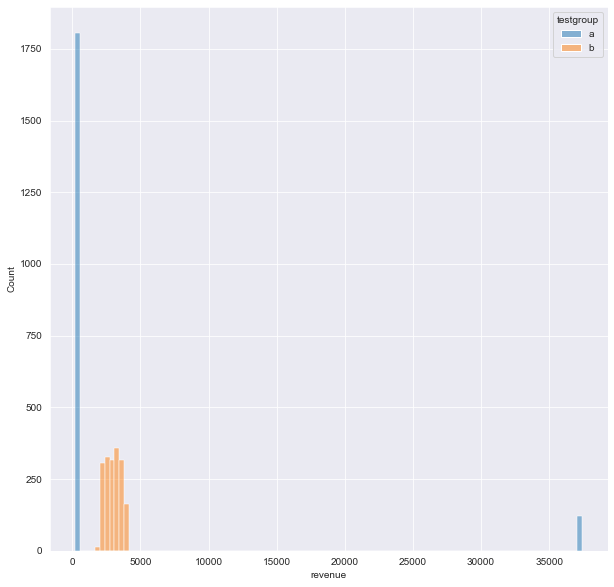

In [17]:
plt.figure(figsize=(10, 10))
sns.histplot(data=test_data.query('revenue > 0'), x='revenue', hue='testgroup')

Группа А имеет разделение на 2 сильно отличные группы. При этом пересечение с группой Б отсутствует.
<br> Рассмотрим группы подробнее.

Text(0.5, 1.0, 'A group. Revenue >= 500')

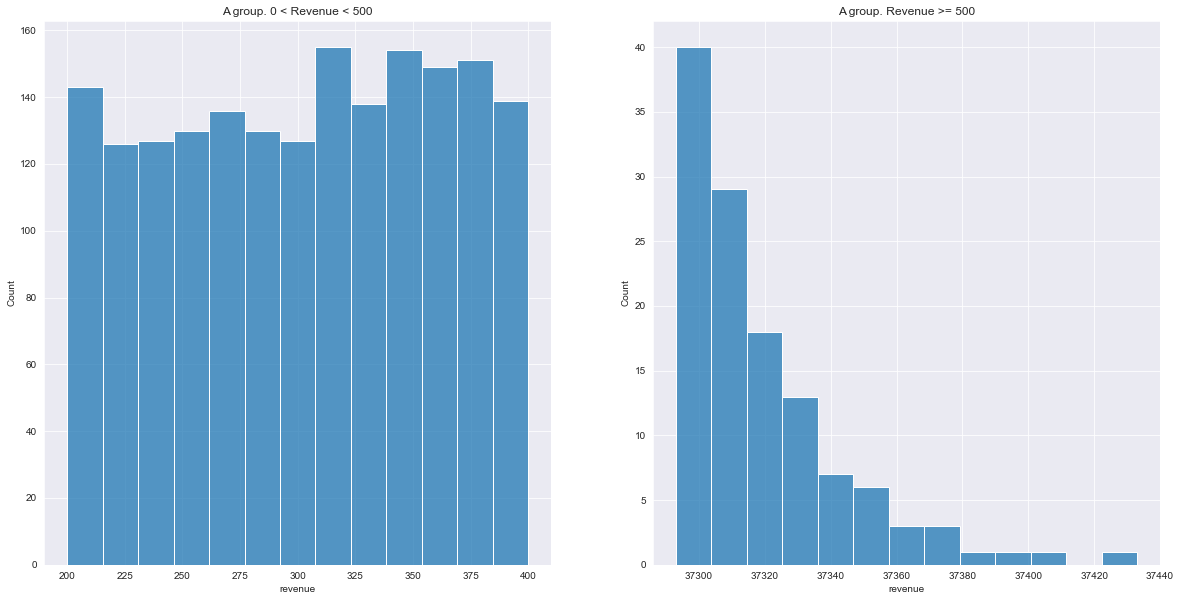

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

plt.rcParams.update({'font.size': 10})

sns.histplot(ax=axes[0], data=test_data.query("0 < revenue < 500 & testgroup == 'a'"), x='revenue')
sns.histplot(ax=axes[1], data=test_data.query("revenue >= 500 & testgroup == 'a'"), x='revenue')


axes[0].set_title('A group. 0 < Revenue < 500')
axes[1].set_title('A group. Revenue >= 500')

Text(0.5, 1.0, 'B group. Revenue > 0')

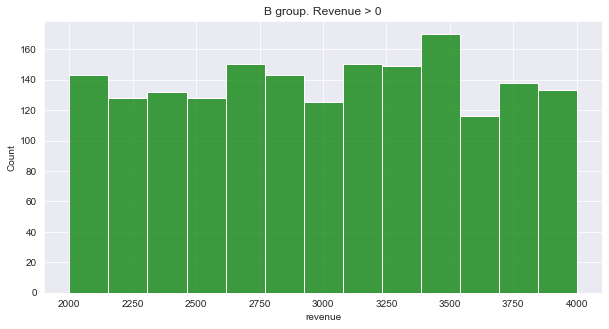

In [19]:
plt.figure(figsize=(10, 5))
sns.histplot(data=test_data.query("revenue > 0 & testgroup == 'b'"), x='revenue', color='g').set_title('B group. Revenue > 0')

In [20]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
        data_column_1, # числовые значения первой выборки
        data_column_2, # числовые значения второй выборки
        boot_it = 1000, # количество бутстрэп-подвыборок
        statistic = np.mean, # интересующая нас статистика
        bootstrap_conf_level = 0.95, # уровень значимости
        need_tqdm = True,
        need_viz = True
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []

    if need_tqdm:

        for _ in tqdm_notebook(range(boot_it)): # извлекаем подвыборки
            samples_1 = data_column_1.sample(
                boot_len,
                replace = True # параметр возвращения
            ).values

            samples_2 = data_column_2.sample(
                boot_len,
                replace = True
            ).values

            boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику

    else:

        for _ in range(boot_it): # извлекаем подвыборки
            samples_1 = data_column_1.sample(
                boot_len,
                replace = True # параметр возвращения
            ).values

            samples_2 = data_column_2.sample(
                boot_len,
                replace = True
            ).values

            boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику

    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = norm.cdf(
        x = 0,
        loc = np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0,
        loc = -np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    if need_viz:

        # Визуализация
        plt.hist(pd_boot_data[0], bins = 50)

        plt.style.use('ggplot')
        plt.vlines(ci,ymin=0, ymax=50, linestyle='--', colors='blue')
        plt.xlabel('boot_data')
        plt.ylabel('frequency')
        plt.title("Histogram of boot_data")
        plt.show()

    return {"boot_data": boot_data,
            "ci": ci,
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

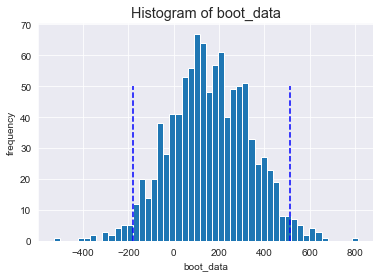

In [21]:
booted_test_data = get_bootstrap(a_group, b_group)

In [22]:
booted_test_data['p_value']

0.37327610100837616

Проведение теста показало, что изменение среднего чека не является стат. значимым.
При этом изменилось соотношение платящих/неплатящих пользователей. Выясним, является ли этот результат стат. значимым.

Использовател bootstrap в данном случае уже не сможем, так как "заплатил/не заплатил" является категорийной переменной. Используем тест хи-вкадрат.

In [23]:
test_data['payed'] = test_data.revenue.apply(lambda x: 1 if x > 0 else 0)

In [24]:
obs = pd.crosstab(test_data.payed, test_data.testgroup)

In [25]:
chi2, p, dof, ex = chi2_contingency(obs, correction=False)

In [26]:
p

0.0350285246428554

In [27]:
obs

testgroup,a,b
payed,,
0,200175,200862
1,1928,1805


In [28]:
ex

array([[200239.10075104, 200797.89924896],
       [  1863.89924896,   1869.10075104]])

P-value < 0.05, следовательно результат является стат. значимым: конверсия в платёж снизилась в группе B.

Итог
Чек стат. значимо не вырос, но при этом стат. значимо уменьшилась конверсия в платёж.  Лучшим набором можно считать набор группы А.

Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

**Ответ:**

Так как не указано, с чем проводится сравнение последнего прошедшего события, предположу, что сравнение происходит с игркой вне ивентов.
1. Так как имеется ограничение по времени и при этом требуется пройти ряд уровней за определённое время, **время сессии** игрока значимо увеличится.
2. Уникальные бонусы и награды должны привлечь игроков, которые, хоть и нечасто играют, зайдут только для того, чтобы получить эти бонусы. Поэтому **retention** тоже можно принять в качестве оценки. Так как привлекаются игроки, **DAW**, **WAU** (в зависимости от периода проведения ивента) увеличатся.
3. Если увеличивается время сессии, увеличивается и вероятность покупки игроком внутриигровой валюты или какой-либо помощи, необходимой для прохождения уровней. Поэтому **revenue** можно принять в качестве метрики. Из этого следует, что **ARP(P)U** также должны увеличиться.
4. Воронка прохождений уровней, участвующих в ивенте, должна измениться: количество пользователей, прошедших N уровней, должно увеличиться.

Если усложнить механику и допустить, что игрок сможет уйти в "минус" по уровням, а бонусы будут настолько хороши, что можно и рискнуть:
1. Предполагаю, что **время сессии** всё равно должно увеличиться.
2. **Retention** также можно использовать в качестве метрики.
3. **Revenue**, **ARP(P)U** в качестве метрик стоит использовать. Возможно, на более поздних уровнях, когда велик шанс проиграть, но и бонус значим, люди будут совершать больше покупок, чтобы не спуститься вниз.
4. Воронка в этом случае, как мне кажется, сместится на начальные уровни, где одновременно велик шанс получить бонус, и шанс проиграть минимален.

Как мне кажется, усложнение механики - это довольно опасно. Постоянных игроков это может оттолкнуть от участия в ивенте из-за рисков, а привлекать новых игроков возможными потерями изначально не стоит. На своей памяти ни одного такого ивента даже и не припомню, что говорит о том, что способ не слишком действенный.